In [1]:
# This notebook is used for testing learning in single units using the draculab module.

# In particular, the Oja learning rule is tested by presenting a set of patterns. The learning rule
# is expected to extract the leading eigenvector of the input correlation matrix.
# In the last cell some of the connection methods are tested a bit.

# By Sergio Verduzco Flores        June 2017

In [2]:
# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..

from draculab import *
import numpy as np
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

/home/z/projects/draculab


In [3]:
def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

def plot_stuff(data, fig):
    fig.clf()
    plt.close()
    fig = plt.figure(figsize=(10,10))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        ax.clear()
        plt.ylim(-0.01,0.5)
        ax.plot(data[0], data[1][i], 'r', figure=fig)
    fig.canvas.draw()
    plt.show()
    

In [4]:

################# TEST 1 ####################
######### 1) Create a network
net_params = {'min_delay' : 0.05, 'min_buff_size' : 4 } # parameter dictionary for the network
n1 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'coordinates' : np.array([0., 0., 0.]), 'function' : lambda x : None,
         'delay' : 1., 'init_val' : 0.5, 'tau_fast' : 1.,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source } 
inputs = n1.create(9,pars) # creating nine input sources
pars['type'] = unit_types.linear
unit = n1.create(1,pars) # creating one linear unit

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : 1.,
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : {'distribution':'uniform', 'low':0.1, 'high':0.5}, 
            'lrate' : 0.02, 'type' : synapse_types.oja} # synapse parameters dictionary
n1.connect(inputs, unit, conn_spec, syn_pars)

######### 4) Running and visualizing 

####### SETTING THE INPUT FUNCTIONS
### You are going to present 4 input patterns that randomly switch over time.
### Imagine the 9 inputs arranged in a grid, like a tic-tac-toe board, numbered
### from left to right and from top to bottom:
### 1 2 3
### 4 5 6
### 7 8 9
### You'll have input patterns
### 0 X 0   0 0 0   X 0 X   0 X 0
### 0 X 0   X X X   0 0 0   X 0 X
### 0 X 0   0 0 0   X 0 X   0 X 0
### The input is always a normalized linear combination of one or two of these patterns.
### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
### 
# here are the patterns as arrays
patterns = [np.zeros(9) for i in range(4)]
patterns[0] = np.array([0., 1., 0., 0., 1., 0., 0., 1., 0.])/3.
patterns[1] = np.array([0., 0., 0., 1., 1., 1., 0., 0., 0.])/3.
patterns[2] = np.array([1., 0., 1., 0., 0., 0., 1., 0., 1.])/4.
patterns[3] = np.array([0., 1., 0., 1., 0., 1., 0., 1., 0.])/4.

n_pres = 100  # number of times some pattern will be presented
t_pat = 10. # as above
t_trans = 4.
c = 1/t_trans # auxiliary variable
pats = range(4) # auxiliary variable
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0.
weights = np.array(n1.units[9].get_weights(n1.sim_time)) # initial weights of the linear unit
start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

fig = plt.figure(figsize=(10,10))
plt.ion()

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat,fig)
    #input('Fixed pattern presented: ' + str(cur_pat))
    #plt.plot(sim_dat[0], sim_dat[1][9])
    #plt.show()
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    #plot_stuff(sim_dat,fig)
    #input('Transitioned to pattern: ' + str(next_pat))
    #plt.plot(sim_dat[0], sim_dat[1][9])
    #plt.show()

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    new_weights = np.array(n1.units[9].get_weights(n1.sim_time))
    weight_diff = new_weights - weights
    weights = new_weights
    if pres%10 == 0:
        print('Presentation ' + str(pres) + ' weight Diff. Sq. norm: ' + str(sum(weight_diff*weight_diff)))

print('Execution time: %s seconds' % (time.time() - start_time))

Presentation 0 weight Diff. Sq. norm: 0.00175841069304
Presentation 10 weight Diff. Sq. norm: 0.000792811627006
Presentation 20 weight Diff. Sq. norm: 0.000949319000619
Presentation 30 weight Diff. Sq. norm: 0.00171152185015
Presentation 40 weight Diff. Sq. norm: 0.00191204141871
Presentation 50 weight Diff. Sq. norm: 0.000794170913939
Presentation 60 weight Diff. Sq. norm: 0.0018719030439
Presentation 70 weight Diff. Sq. norm: 0.000880717770215
Presentation 80 weight Diff. Sq. norm: 0.000916714956449
Presentation 90 weight Diff. Sq. norm: 0.000782472989819
Execution time: 7.192870616912842 seconds


Max eigenvalue: 0.602188329871, index: 2
['0.00', '0.43', '0.00', '0.43', '0.50', '0.43', '0.00', '0.43', '0.00']
['0.03', '0.24', '0.03', '0.56', '0.50', '0.56', '0.03', '0.23', '0.03']


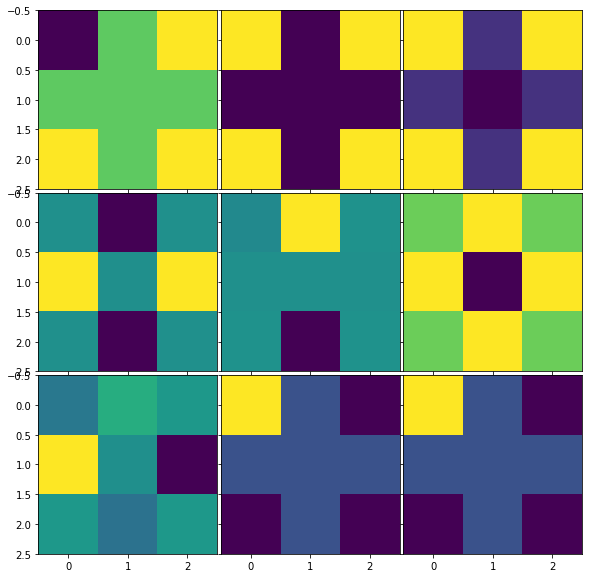

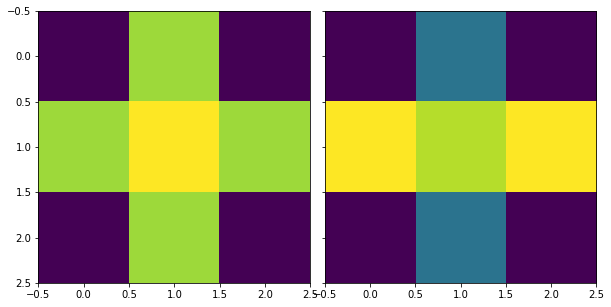

In [5]:
#### Comparing the weight vector with the leading eigenvector of the correlation matrix
#######################################################################################

weights = np.array(n1.units[9].get_weights(n1.sim_time))

# Obtaining eigenvectors of the correlation matrix
pat_mat = np.matrix(patterns)
corr = (pat_mat.T)*pat_mat # input correlation matrix
eigs = np.linalg.eig(corr) # extracting eigenvalues and eigenvectors
evals = eigs[0] # eigenvalues
evecs = [eigs[1][:,i] for i in range(9)] # eigenvectors

# obtaining the leading eigenvector
max_index, max_value = max(enumerate(evals), key=lambda p:p[1])
print('Max eigenvalue: ' + str(max_value) + ', index: ' + str(max_index))
max_evector = evecs[max_index]
    
# plotting all eigenvectors in 3x3 format
fig3 = plt.figure(figsize=(10,10))
ev_grid = ImageGrid(fig3, 111, nrows_ncols=(3,3), axes_pad=0.05)
for idx,vec in enumerate(evecs):
    vec.shape = 3,3
    ev_grid[idx].imshow(vec)

# plotting leading eigenvector VS weight vector in 3x3 format
fig4 = plt.figure(figsize=(12,5))
sp_ev_grid = ImageGrid(fig4, 111, nrows_ncols=(1,2), axes_pad=0.2)
for idx,vec in enumerate([-max_evector, weights]):
    vec.shape = 3,3
    sp_ev_grid[idx].imshow(vec)
    print(["%.2f" % float(v[0]) for v in vec.reshape(9,1)])


['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.3', '0.0', '0.0', '0.5', '0.3', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.5', '0.0', '0.3', '0.0', '0.4', '0.0', '0.0', '0.0']
['1.0', '0.0', '0.0', '0.0', '0.3', '0.0', '0.0', '0.6', '0.0', '0.0', '0.0', '0.0', '0.1', '0.7']
['0.0', '1.0', '0.0', '0.0', '0.0', '0.6', '0.0', '0.2', '0.0', '0.6', '0.0', '0.7', '0.0', '0.0']
['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.5', '0.0', '0.0', '0.3', '0.0', '0.1', '0.0']
['0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.5', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.2']
['0.0', '0

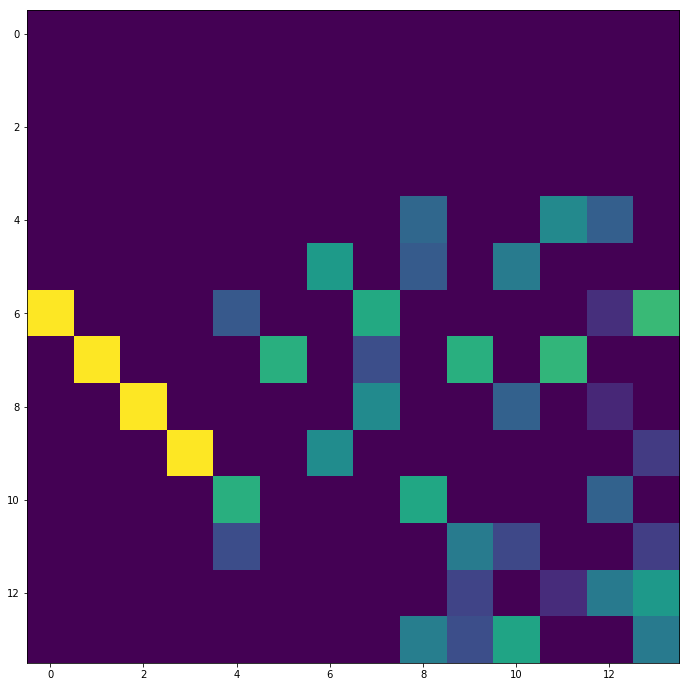

In [6]:
# testing conn_spec rules and syn_par specifications
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network
n2 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'coordinates' : np.array([0., 0., 0.]), 'function' : lambda x:None,
         'delay' : 1., 'init_val' : 0.5, 'tau_fast' : 1.,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source } 
inputs = n2.create(4,pars) # creating input sources
pars['type'] = unit_types.sigmoidal
sigs = n2.create(10,pars) # creating sig units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'one_to_one', 'indegree' : 4, 'outdegree' : 5, 'delay' : 1.,
             'allow_autapses' : True, 'allow_multapses' : True } # connection specification dictionary
syn_pars = {'init_w' : 1, 'lrate' : 0.01, 
            'type' : synapse_types.oja} # synapse parameters dictionary
n2.connect(inputs, sigs[2:6], conn_spec, syn_pars)
#print(conn_mat(n2))
syn_pars['init_w'] = {"distribution" : 'uniform', 'low' : 0.1, 'high' : 0.7}
conn_spec['rule'] = 'fixed_indegree'
n2.connect(sigs, sigs, conn_spec, syn_pars)
C = conn_mat(n2)
for row in C:
    print(["{0:0.1f}".format(i) for i in row])

fig5 = plt.figure(figsize=(12,12))
conn_grid = ImageGrid(fig5, 111, nrows_ncols=(1,1), axes_pad=0.2)
conn_grid[0].imshow(C)


In [7]:
for syn in n2.syns[sigs[9]]:
    print(" (%d,%d)" % (syn.preID, syn.postID))

 (8,13)
 (13,13)
 (10,13)
 (9,13)
